In [1]:
import matplotlib.pyplot as plt
from betabin import BetaBinomialMarkovChain
from gridaprox import OneDGridAprox
from ar1compact import AR1Compact1D
from compactdist import Beta
import numpy as np
import scipy.integrate as spi
from scipy.integrate import quad_vec
from scipy.stats import binom, beta as beta_dist
from utils import analytic_stationary_mean_var

## 1) Explicit transition kernel

Let $X \in (0,1)$. Given $X=x$, draw
$$
S \mid X=x \sim \mathrm{Binomial}(n,x),
\qquad
p_{S\mid X}(k\mid x;n)=\binom{n}{k}x^k(1-x)^{n-k}.
$$
Then draw
$$
Y \mid S=k \sim \mathrm{Beta}(\alpha+k,\beta+n-k),
$$
so the conditional density is
$$
f_{Y\mid S}(y\mid k;\alpha,\beta,n)
=\frac{1}{B(\alpha+k,\beta+n-k)}y^{\alpha+k-1}(1-y)^{\beta+n-k-1},\quad y\in(0,1).
$$

Therefore the transition density kernel is
$$
\boxed{
K(x,y;\alpha,\beta,n)=\sum_{k=0}^n
\binom{n}{k}x^k(1-x)^{n-k}\;
\frac{1}{B(\alpha+k,\beta+n-k)}y^{\alpha+k-1}(1-y)^{\beta+n-k-1}
}
$$
for $x,y\in(0,1)$.

## 2) Stationarity of $\mathrm{Beta}(\alpha,\beta)$ via the balance equation

Let $\pi$ denote the $\mathrm{Beta}(\alpha,\beta)$ density
$$
\pi(x)=\frac{1}{B(\alpha,\beta)}x^{\alpha-1}(1-x)^{\beta-1},\quad x\in(0,1).
$$
We want to show
$$
\boxed{
\pi(y)=\int_0^1 K(x,y;\alpha,\beta,n)\,\pi(x)\,dx
}
\quad \text{for all }y\in(0,1).
$$

Start from the RHS and substitute $K$:
$$
\int_0^1 K(x,y)\,\pi(x)\,dx
=
\int_0^1 \left(\sum_{k=0}^n f_{Y\mid S}(y\mid k)\,p_{S\mid X}(k\mid x)\right)\pi(x)\,dx.
$$
Since the sum has finitely many terms, swap sum and integral:
$$
=
\sum_{k=0}^n f_{Y\mid S}(y\mid k)\int_0^1 p_{S\mid X}(k\mid x)\,\pi(x)\,dx.
$$

Define the marginal pmf of $S$ when $X\sim \mathrm{Beta}(\alpha,\beta)$:
$$
p_S(k;\alpha,\beta,n):=\int_0^1 p_{S\mid X}(k\mid x;n)\,\pi(x)\,dx.
$$

Now consider the joint law $X\sim \mathrm{Beta}(\alpha,\beta)$, $S\mid X\sim \mathrm{Binomial}(n,X)$. Then
$$
X\mid(S=k)\sim \mathrm{Beta}(\alpha+k,\beta+n-k).
$$
By construction also
$$
Y\mid(S=k)\sim \mathrm{Beta}(\alpha+k,\beta+n-k).
$$
Hence $f_{Y\mid S}(y\mid k)=f_{X\mid S}(y\mid k)$ for all $k$ and $y\in(0,1)$.

Therefore
$$
\int_0^1 K(x,y)\,\pi(x)\,dx
=
\sum_{k=0}^n f_{Y\mid S}(y\mid k)\,p_S(k;\alpha,\beta,n)
=
\sum_{k=0}^n f_{X\mid S}(y\mid k)\,p_S(k;\alpha,\beta,n)
=
f_X(y)=\pi(y).
$$

So $\mathrm{Beta}(\alpha,\beta)$ is stationary.


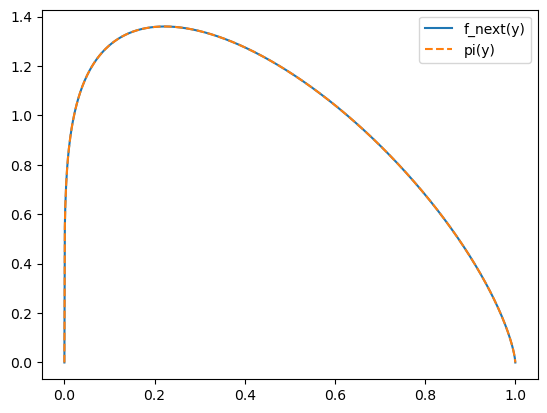

L1 grid error: 5.55537425089847e-10
quad_vec error estimate norm: 3.2664626045043824e-08


In [2]:
# ----------------------------
# Demo: stationarity check
# ----------------------------
Chain = BetaBinomialMarkovChain(x_0=0.5, n=10, alpha=1.2, beta=1.7)

y = np.linspace(0, 1, 1000)
res, err = Chain.NextDistribution_quadvec(y, beta_dist.pdf, Chain.alpha, Chain.beta)

plt.plot(y, res, label="f_next(y)")
plt.plot(y, beta_dist.pdf(y, Chain.alpha, Chain.beta), "--", label="pi(y)")
plt.legend()
plt.show()

print("L1 grid error:", np.sum(np.abs(beta_dist.pdf(y, Chain.alpha, Chain.beta) - res)))
print("quad_vec error estimate norm:", err)


In [3]:
Chain = BetaBinomialMarkovChain(x_0=0.5, n=10, alpha=1.2, beta=1.7)
Chain.test_error(0.0001, 5, "moment", 1)

9.055210686836901e-08

E[X] (moment 1) : ['2.30e-03', '6.68e-04', '1.40e-04', '1.84e-05', '4.76e-06', '6.33e-06', '4.29e-06', '2.47e-06', '1.33e-06', '6.91e-07', '3.54e-07', '1.79e-07', '9.06e-08']
E[X^2] (moment 2) : ['2.56e-03', '8.28e-04', '2.14e-04', '5.01e-05', '8.56e-06', '6.70e-07', '1.88e-06', '1.41e-06', '8.50e-07', '4.70e-07', '2.49e-07', '1.29e-07', '6.61e-08']
E[X(1-X)] (p=1,q=1) : ['2.56e-04', '1.60e-04', '7.45e-05', '3.18e-05', '1.33e-05', '5.66e-06', '2.41e-06', '1.06e-06', '4.77e-07', '2.21e-07', '1.04e-07', '5.02e-08', '2.44e-08']
E[X(1-X)^2] (1,2) : ['2.06e-04', '1.11e-04', '4.71e-05', '1.85e-05', '7.09e-06', '2.73e-06', '1.04e-06', '4.10e-07', '1.65e-07', '6.92e-08', '3.01e-08', '1.35e-08', '6.26e-09']
E[log X] : ['2.74e-02', '1.27e-02', '5.54e-03', '2.54e-03', '1.21e-03', '5.96e-04', '2.92e-04', '1.44e-04', '7.16e-05', '3.56e-05', '1.77e-05', '8.81e-06', '4.38e-06']
E[log(1-X)] : ['7.48e-03', '2.73e-03', '8.48e-04', '2.61e-04', '7.91e-05', '2.23e-05', '4.94e-06', '2.91e-07', '6.40e-07', '

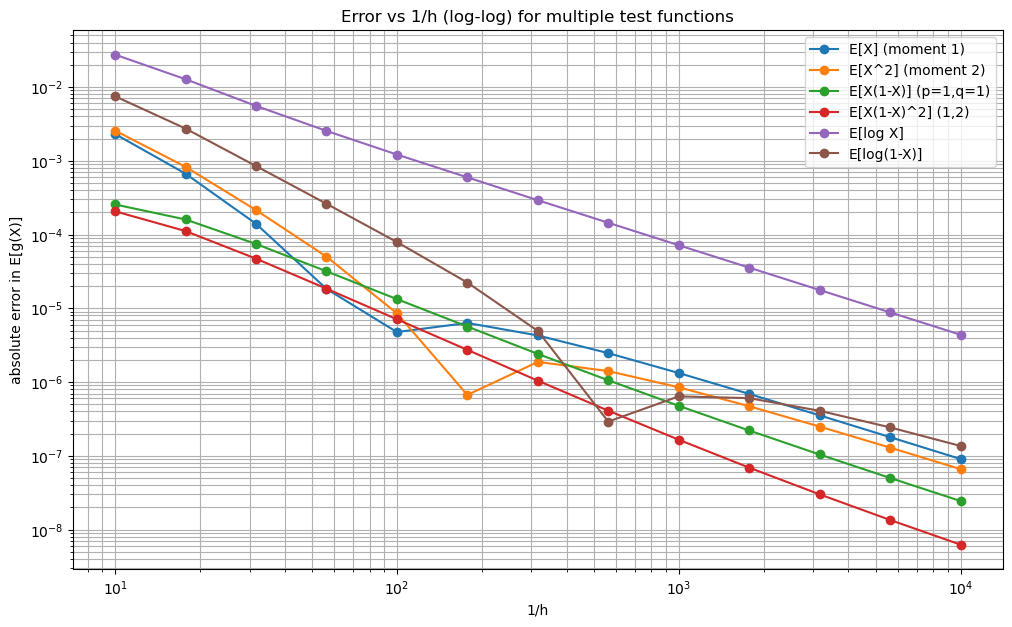

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Assumes BetaBinomialMarkovChain is defined/imported and Chain.test_error works.
# Also assumes your gridaprox/test_function setup supports:
#   "moment", r
#   "beta_mixed", p, q
#   "logx"
#   "log1mx"

Chain = BetaBinomialMarkovChain(x_0=0.5, n=10, alpha=1.2, beta=1.7)

m = 5
hs = np.logspace(-1, -4, 13)  # h from 1e-1 to 1e-4
inv_h = 1.0 / hs

# Define the reward/test functions you want:
tests = [
    ("E[X] (moment 1)",      ("moment", 1)),
    ("E[X^2] (moment 2)",    ("moment", 2)),
    ("E[X(1-X)] (p=1,q=1)",  ("beta_mixed", 1, 1)),  # your "beta(1,1)" style
    ("E[X(1-X)^2] (1,2)",    ("beta_mixed", 1, 2)),  # your "beta(1,2)" style
    ("E[log X]",             ("logx",)),
    ("E[log(1-X)]",          ("log1mx",)),
]

plt.figure(figsize=(12, 7))

for label, spec in tests:
    name = spec[0]
    params = spec[1:]

    errs = []
    for h in hs:
        e = Chain.test_error(float(h), m, name, *params)
        errs.append(e)

    errs = np.asarray(errs, dtype=float)
    plt.loglog(inv_h, errs, marker="o", label=label)
    print(label, ":", ["{:.2e}".format(x) for x in errs])

plt.xlabel("1/h")
plt.ylabel("absolute error in E[g(X)]")
plt.title("Error vs 1/h (log-log) for multiple test functions")
plt.grid(True, which="both")
plt.legend()
plt.show()


## Almost closed-form stationary distribution benchmark via characteristic functions (multivariate AR(1) on $[0,1]^d$)

We consider a $d$-dimensional autoregressive Markov chain on the compact domain $[0,1]^d$:
$$
X_{n+1}=A X_n + B Z_{n+1},
$$
where:

- $A\in\mathbb{R}^{d\times d}$ is a stable matrix with spectral radius $\rho(A)<1$,
- $B$ is typically diagonal (or any matrix chosen so that $AX + BZ\in[0,1]^d$ whenever $X,Z\in[0,1]^d$),
- $Z_n=(Z_{n,1},\dots,Z_{n,d})$ are i.i.d. innovations with **independent coordinates** supported on $[0,1]$ (e.g. Beta or truncated Normal), independent across time.

A convenient sufficient invariance condition (no clipping needed) is:
- $A_{ij}\ge 0$ and $\sum_{j=1}^d A_{ij} + (B\mathbf{1})_i \le 1$ for each $i$,
so that $AX + BZ \in [0,1]^d$ for all $X,Z\in[0,1]^d$.


### 1) Stationary solution as a convergent series

Since $\rho(A)<1$, the chain admits a unique stationary distribution and we have the stationary representation
$$
X \;\overset{d}{=}\; \sum_{k=0}^{\infty} A^k B Z_{-k},
$$
where $Z_{-k}$ are i.i.d. copies of $Z$.

This is the multivariate analogue of the classical AR(1) perpetuity representation. It is the key reason we can obtain an **almost closed-form** benchmark for the stationary law.


### 2) Characteristic function factorization

Let $\varphi_X(t)=\mathbb{E}[e^{i t^\top X}]$ for $t\in\mathbb{R}^d$.
Using independence across $k$ and the identity
$$
t^\top(A^k B Z) = \big((B^\top (A^k)^\top t)\big)^\top Z,
$$
we obtain the exact factorization
$$
\boxed{
\varphi_X(t)=\prod_{k=0}^{\infty} \varphi_Z\!\left(B^\top (A^k)^\top t\right),
}
$$
where $\varphi_Z(u)=\mathbb{E}[e^{i u^\top Z}]$ is the innovation CF.

If the coordinates of $Z$ are independent, then
$$
\varphi_Z(u)=\prod_{j=1}^d \varphi_{Z_j}(u_j),
$$
so evaluation reduces to 1D CF computations.

**Examples with easy 1D CFs on $[0,1]$:**
- $Z_j\sim\mathrm{Beta}(a_j,b_j)$: $\varphi_{Z_j}(t)={}_1F_{1}(a_j;\,a_j+b_j;\,it)$.
- $Z_j\sim\mathcal{N}(\mu_j,\sigma_j^2)$ truncated to $[0,1]$:
  $$
  \varphi_{Z_j}(t)=\frac{e^{it\mu_j-\sigma_j^2 t^2/2}}{Z_j}
  \left[\Phi\!\left(\frac{1-\mu_j}{\sigma_j}-it\sigma_j\right)-\Phi\!\left(\frac{-\mu_j}{\sigma_j}-it\sigma_j\right)\right],
  $$
  where $Z_j=\Phi((1-\mu_j)/\sigma_j)-\Phi(-\mu_j/\sigma_j)$.


### 3) Fast truncation using eigenvalues of $A$

To compute $\varphi_X(t)$ numerically, truncate the infinite product at $K$:
$$
\varphi_X(t)\approx \prod_{k=0}^{K} \varphi_Z\!\left(B^\top (A^k)^\top t\right).
$$

This is **extremely fast** because $(A^k)^\top t$ decays geometrically:
- if $\|A^k\|\le C\gamma^k$ for some $\gamma\in(0,1)$ (e.g. $\gamma\approx\rho(A)$),
then
$$
\|B^\top (A^k)^\top t\| \le \|B\|\,\|A^k\|\,\|t\| \le \|B\|\,C\,\gamma^k \|t\|.
$$

Hence, for any frequency cutoff $t_{\max}$ (as required by FFT inversion), the number of terms needed is on the order of
$$
K \;\approx\; \frac{\log(\varepsilon/\|t\|)}{\log(\gamma)},
$$
to make $\|B^\top (A^K)^\top t\|\lesssim \varepsilon$.

**Smaller eigenvalues / smaller $\rho(A)$ $\Rightarrow$ fewer terms.**
For example, if $\rho(A)\approx 0.5$, then $K\in[15,40]$ is often sufficient even for fairly large $t_{\max}$.


### 4) Tail estimation via log-CF expansion

Instead of discarding the tail, use a cumulant expansion for small arguments. For small $u\in\mathbb{R}^d$,
$$
\log \varphi_Z(u)
= i\,\mu^\top u - \tfrac{1}{2}u^\top \Sigma u + O(\|u\|^3),
$$
where $\mu=\mathbb{E}[Z]$ and $\Sigma=\mathrm{Cov}(Z)$ (easy to compute for Beta/truncated Normal).

Then
$$
\log\varphi_X(t)
= \sum_{k=0}^K \log\varphi_Z\!\left(B^\top (A^k)^\top t\right)
\;+\;\underbrace{\sum_{k=K+1}^\infty \log\varphi_Z\!\left(B^\top (A^k)^\top t\right)}_{\text{tail}}.
$$

Approximate the tail by substituting the quadratic expansion:
$$
\sum_{k=K+1}^\infty \log\varphi_Z(u_k)
\approx i\,\mu^\top \sum_{k=K+1}^\infty u_k
-\tfrac12 \sum_{k=K+1}^\infty u_k^\top \Sigma u_k,
\qquad u_k=B^\top(A^k)^\top t.
$$

The linear tail is a matrix geometric series:
$$
\sum_{k=K+1}^\infty (A^k)^\top t
=\left(A^{K+1}\right)^\top (I-A^\top)^{-1} t,
$$
so
$$
\sum_{k=K+1}^\infty u_k
= B^\top \left(A^{K+1}\right)^\top (I-A^\top)^{-1} t.
$$

This yields a **high-accuracy tail correction** at essentially no cost.

Implementation detail: compute the CF stably as
$$
\varphi_X(t)=\exp\!\left(\sum_{k=0}^K \log\varphi_Z(u_k)+\widehat{\mathrm{tail}}(t)\right),
$$
which avoids underflow/overflow and improves numerical stability.


### 5) Recovering the stationary density by inverse FFT

Once $\varphi_X(t)$ is available on a frequency grid, we can approximate the stationary density (or distribution) via inverse Fourier transform. In 1D this is classical FFT inversion; in 2D it is a 2D inverse FFT. For $d=3$, the same idea works but grid sizes grow quickly.

Key numerical requirements:
- choose an $x$-domain size $L$ large enough to avoid wrap-around,
- choose a frequency cutoff $t_{\max}$ so that $|\varphi_X(t)|$ is negligible near the boundary,
- use sufficient resolution to resolve the density features.

Because $\varphi_X$ can be evaluated very cheaply and accurately, FFT inversion becomes a practical way to produce a **near-truth stationary density**.


### 6) Error analysis and why this is an excellent benchmark

There are two main approximation errors:

#### (a) Truncation/tail error in $\varphi_X$
If $\|A^k\|\le C\gamma^k$, then $\|u_k\|\le \|B\|C\gamma^k\|t\|$.
Using $\log\varphi_Z(u)= i\mu^\top u - \tfrac12 u^\top\Sigma u + O(\|u\|^3)$,
the remainder in the log-CF tail after quadratic correction scales like
$$
\sum_{k=K+1}^\infty O(\|u_k\|^3)
\;=\;O\!\left(\|t\|^3 \sum_{k=K+1}^\infty \gamma^{3k}\right)
\;=\;O\!\left(\|t\|^3 \frac{\gamma^{3(K+1)}}{1-\gamma^3}\right).
$$
Thus, for fixed frequency range $\|t\|\le t_{\max}$, increasing $K$ improves accuracy **geometrically** at rate $\gamma^{3K}$ (or faster if higher-order tail terms are used).

This explains why small eigenvalues / small $\rho(A)$ give extremely fast convergence.

#### (b) FFT inversion error
FFT inversion error is controlled by:
- truncation in frequency (choose $t_{\max}$ large enough),
- aliasing (choose spatial period $L$ large enough),
- discretization resolution (grid size).

These can be tuned independently. Since $\varphi_X$ evaluation is cheap, increasing FFT resolution is often feasible.



## 1D “test case” final formula: $X_{n+1}=(1-\lambda)X_n+\lambda Z_{n+1}$ on $[0,1]$

Assume $\lambda\in(0,1)$ and $Z_n\in[0,1]$ i.i.d. (e.g. $Z\sim\mathrm{Beta}(a,b)$ or $Z$ is a Normal truncated to $[0,1]$).  
Then the chain stays in $[0,1]$ and has a unique stationary distribution.

Let $\rho = 1-\lambda$. A practical “almost closed-form” approximation truncates the product at $K$:
$$
\boxed{
\varphi_X^{(K)}(t)
=\prod_{k=0}^{K}\varphi_Z\!\big(\lambda\,\rho^k\,t\big).
}
$$


### Tail correction 
Let $\mu=\mathbb{E}[Z]$ and $v=\mathrm{Var}(Z)$.  
For small $u$, $\log\varphi_Z(u)= i\mu u-\tfrac12 v u^2+O(|u|^3)$, so we approximate
$$
\log\varphi_X(t)
=\sum_{k=0}^{K}\log\varphi_Z(\lambda\rho^k t)\;+\;\mathrm{Tail}_K(t),
$$
with the quadratic tail correction
$$
\boxed{
\mathrm{Tail}_K(t)
\approx i\mu\,t\,\lambda\sum_{k=K+1}^{\infty}\rho^k
-\frac12 v\,t^2\,\lambda^2\sum_{k=K+1}^{\infty}\rho^{2k}
=
i\mu\,t\,\rho^{K+1}
-\frac12 v\,t^2\,\lambda^2\frac{\rho^{2(K+1)}}{1-\rho^2}.
}
$$

Then the “corrected” CF is
$$
\boxed{
\widehat{\varphi}_X^{(K)}(t)
=\exp\!\left(\sum_{k=0}^{K}\log\varphi_Z(\lambda\rho^k t)\;+\;\mathrm{Tail}_K(t)\right).
}
$$





Beta innovation test
-------------------
Numerical mean: 0.41379310344827325
Analytic mean : 0.41379310344827586
Abs mean err  : 2.609024107869118e-15

Numerical var : 0.02073233940059118
Analytic var  : 0.020732339400591483
Abs var err   : 3.0184188481996443e-16

Integral of f : 1.0


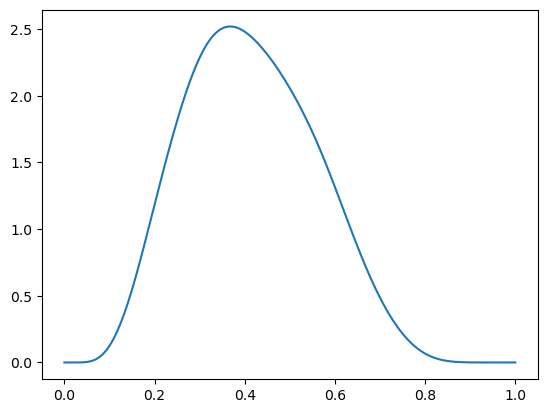

In [5]:
def validate_beta_ar1():
    rng = np.random.default_rng(0)

    a, b = 1.2, 1.7
    innov = Beta(a=a, b=b, m_cf=200, rng=rng)

    lam = 0.5
    chain = AR1Compact1D(x0=0.5, lam=lam, innov=innov)

    # Compute stationary density
    x, f = chain.stationary_density_cf_fft(
        N=2**10,
        L=4.0,
        eps_u=1e-8,         
    )

    # Moments from recovered density
    mean_num = np.trapz(x * f, x)
    var_num = np.trapz((x - mean_num) ** 2 * f, x)

    mean_true, var_true = analytic_stationary_mean_var(lam, innov.mean(), innov.var())

    print("Beta innovation test")
    print("-------------------")
    print("Numerical mean:", mean_num)
    print("Analytic mean :", mean_true)
    print("Abs mean err  :", abs(mean_num - mean_true))
    print()
    print("Numerical var :", var_num)
    print("Analytic var  :", var_true)
    print("Abs var err   :", abs(var_num - var_true))
    print()
    print("Integral of f :", np.trapz(f, x))
    plt.plot(x, f)


validate_beta_ar1()